In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup 
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [2]:
train = pd.read_csv("../datasets/imdb-dataset/labeledTrainData.tsv", header=0,\
                    delimiter="\t", quoting=3)
test = pd.read_csv("../datasets/imdb-dataset/testData.tsv",header=0,\
                    delimiter="\t", quoting=3)

In [3]:
def preprocess_review(review):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    words = review_text.lower().split()
    stops = stopwords.words("english")   
    words = [w for w in words if not w in stops]
    return(words)

In [4]:
def reviews_to_sentences(review):
    raw_sentences = sent_tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(preprocess_review(raw_sentence))
    return sentences

In [5]:
sentences = []
for review in train["review"]:
    sentences += reviews_to_sentences(review)

//anaconda3/envs/nlpCourse/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
//anaconda3/envs/nlpCourse/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [6]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in train['review']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
sentences = phrases[sent]

In [7]:
num_features = 300  
min_word_count = 40 
num_workers = 4     
context = 10        
downsampling = 1e-3 # (0.001) 

from gensim.models import word2vec
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

model.init_sims(replace=True)

In [10]:
model.wv.doesnt_match("king queen princess".split())

'king'

In [11]:
model.wv.most_similar("queen")

[('waitress', 0.8620313405990601),
 ('husband,', 0.8453359603881836),
 ('neighbor', 0.8356812596321106),
 ('secretary', 0.8344413638114929),
 ('lover,', 0.8326244354248047),
 ('princess', 0.8311485052108765),
 ('finds_herself', 0.826461911201477),
 ('sister,', 0.8258087635040283),
 ('widow', 0.825401246547699),
 ('daughter,', 0.8237282037734985)]

In [12]:
model.wv.most_similar("house")

[('hotel', 0.864335298538208),
 ('house,', 0.8605543375015259),
 ('town,', 0.84136962890625),
 ('party', 0.8393861055374146),
 ('train', 0.8355211615562439),
 ('woods', 0.8280991315841675),
 ('cabin', 0.8225177526473999),
 ('hospital', 0.8201355934143066),
 ('kitchen', 0.8176299333572388),
 ('apartment', 0.8172283172607422)]

In [13]:
model.wv.most_similar(positive=["movie"])

[('movie,', 0.8048056364059448),
 ('this_movie', 0.6905909776687622),
 ('movie.', 0.6804574131965637),
 ('movie._It', 0.6350410580635071),
 ('flick', 0.6259576082229614),
 ('movie...', 0.5990220308303833),
 ('film', 0.5723241567611694),
 ('this_movie,', 0.5696083307266235),
 ('sequel', 0.5612514019012451),
 ('film._It', 0.5610654354095459)]

In [14]:
model.wv.most_similar(negative=["victim"])

[('crappy', 0.5514270067214966),
 ('on_IMDb', 0.5319653749465942),
 ('MST3K', 0.5210133194923401),
 ('sci-fi', 0.48909732699394226),
 ('Disney', 0.48331254720687866),
 ('low_budget', 0.47897642850875854),
 ('personally', 0.47567957639694214),
 ('IMDb', 0.4744868874549866),
 ('after_watching', 0.47350412607192993),
 ('quality', 0.4692881107330322)]

In [15]:
model.wv.syn0.shape

//anaconda3/envs/nlpCourse/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(10805, 300)

In [18]:
from collections import defaultdict
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

291512

In [19]:
from collections import defaultdict
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'in', 'that', 'it', 'was']

In [ ]:
model.wv.most_similar(positive=["great_movie"])

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [29]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar([word])

    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)

    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                    }
                    )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

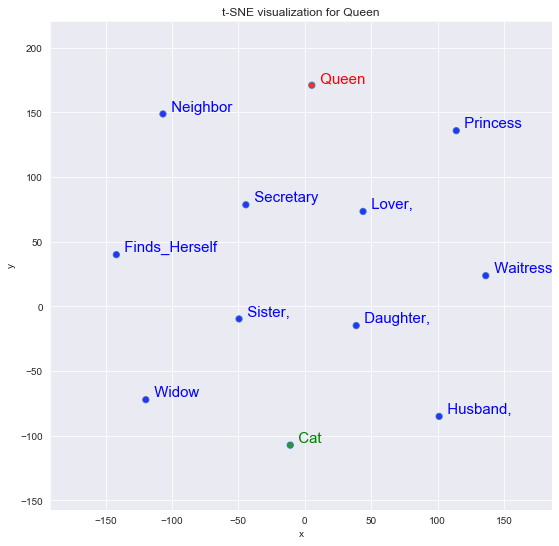

In [30]:
tsnescatterplot(model, 'queen', ['cat'])

In [34]:
def featureVecMethod(words, model, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])

    featureVec = np.divide(featureVec, nwords)
    return featureVec
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs
clean_train_reviews = []
for review in train['review']:
    clean_train_reviews.append(preprocess_review(review))
    
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

//anaconda3/envs/nlpCourse/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [36]:
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(preprocess_review(review))
    
testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

//anaconda3/envs/nlpCourse/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [37]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(trainDataVecs, train["sentiment"])

In [38]:
result = forest.predict(testDataVecs)
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})

In [39]:
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1


In [19]:
test.head()["review"][3]

'"Afraid of the Dark left me with the impression that several different screenplays were written, all too short for a feature length film, then spliced together clumsily into this Frankenstein\'s monster.<br /><br />At his best, the protagonist, Lucas, is creepy. As hard as it is to draw a bead on the secondary characters, they\'re far more sympathetic.<br /><br />Afraid of the Dark could have achieved mediocrity had it taken just one approach and seen it through -- and had it made Lucas simply psychotic and confused instead of ghoulish and off-putting. I wanted to see him packed off into an asylum so the rest of the characters could have a normal life."'

In [41]:
output.to_csv("output.csv", index=False, quoting=3 )

In [42]:
model.save("word2vec.model")